<a href="https://colab.research.google.com/github/ankesh86/DiffusionModels/blob/main/GANS/DeepConvolutionalGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import  numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _),(_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape


(60000, 28, 28)

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28,1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [4]:
train_images.shape

(60000, 28, 28, 1)

In [5]:
buffer_size = 60000
batch_size = 128

In [6]:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [7]:
def generator_model():

  model = tf.keras.Sequential()
  model.add(layers.Dense(7 * 7 * 256, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', activation='tanh'))

  return model

In [8]:
generator = generator_model()

generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,318,209 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [9]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 28, 28, 1])

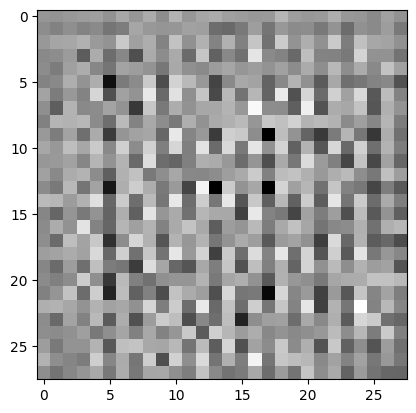

In [10]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', input_shape=[28, 28, 1]))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2DTranspose(128, (5,5), strides = (2,2), padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [12]:
discriminator = discriminator_model()

discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 56, 56, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 112, 112, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1605632)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │       1,605,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,812,993 (6.92 MB)

 Trainable params: 1,812,609 (6.91 MB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
discriminator = discriminator_model()
output = discriminator(generated_image)

print(output)

tf.Tensor([[0.49990806]], shape=(1, 1), dtype=float32)


## Defining loss-func

In [14]:
bce = tf.keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(real_output, fake_output):

  real_loss = bce(tf.ones_like(real_output), real_output)
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [16]:
def generator_loss(fake_output):

  gen_loss = bce(tf.ones_like(fake_output), fake_output)

  return gen_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


## Starting training process

In [19]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
def generate_and_plot_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize = (8,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    pred = (predictions[i, :, :, 0] + 1)* 127.5
    pred = np.array(pred)
    plt.imshow(pred.astype(np.uint8), cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #print('Generator started')
    generated_images = generator(noise, training = True)
    #print('Generator ended')

    print('real discriminator started')
    real_output = discriminator(images, training = True)
    #print('real discriminator ended, fake started')

    fake_output = discriminator(generated_images, training=True)
    #print('fake discriminator ended')

    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [22]:
def train(dataset, epochs):

  gen_loss_list = []
  disc_loss_list = []

  real_score_list = []
  fake_score_list = []

  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f'Training started with epoch {epoch + 1} with {num_batches} batches...')

    total_gen_loss = 0
    total_disc_loss = 0

    for batch in dataset:
      #print('Batch started')
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss
      #print('Batch ended')

    mean_gen_loss = total_disc_loss/num_batches
    mean_disc_loss = total_disc_loss/ num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
     (epoch+1, generator_loss, discriminator_loss, real_score*100, fake_score*100))

    generate_and_plot_images(generator, epoch+1, seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch+1)%10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches...
real discriminator started
real discriminator started
real discriminator started
Losses after epoch     1: generator 10.529, discriminator 1.421, real_score 88.37%, fake_score 13.30%


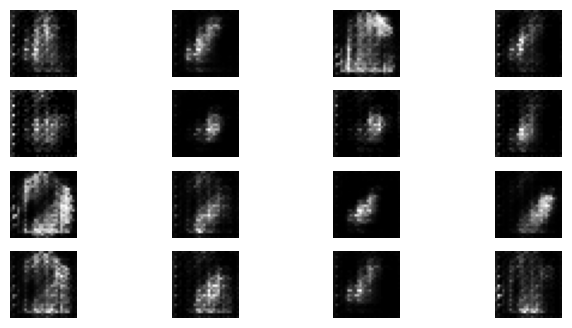

  2%|▏         | 1/50 [08:37<7:02:18, 517.12s/it]

Time for epoch 1 is 517.1195466518402 sec
Training started with epoch 2 with 469 batches...


In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.plot(gen_loss_epochs, label='Generator Loss', alpha=0.5)
ax1.plot(disc_loss_epochs, label='Discriminator Loss', alpha=0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label='Real score', alpha=0.5)
ax2.plot(fake_score_list, label='Fake score', alpha=0.5)
ax2.set_title('Accuracy Scores')
ax2.legend()